<a href="https://colab.research.google.com/github/JuanjoRestrepo/Machine-Learning-and-AI/blob/main/Desarrollo_Parcial2_Ceballos_Restrepo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hecho por: Isabella Ceballos y Juan José Restrepo**

# Parcial 2. Clasificación de imágenes a partir de redes Convolucionales.

En esta actividad se aborda el problema de la clasificación de imágenes utilizando la base de datos CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html). Cada grupo de trabajo deberá diseñar y ejecutar una solución basada en redes neuronales convolucionales. Se considerarán dos aspectos principales para la evaluación del trabajo:

1. Planeación: antes de comenzar a diseñar cualquier modelo, cada grupo debe describir detalladamente la solución que plantea. Es importante que se justifiquen todas las decisiones tomadas (por ejemplo, la función de costo y la función de activación en la capa de salida). Además, se deben tener en cuenta características como el tipo de imágenes (a color), la cantidad de datos en el conjunto de entrenamiento y la cantidad de clases. Este elemento representa el 30% de la nota.

2. Ejecución: una vez descrita la solución propuesta, se procede a su implementación. Cada grupo debe asegurarse de que la implementación siga fielmente lo descrito en la propuesta, y justificar cualquier cambio que se realice en la ejecución. Este elemento representa el 70% de la nota.


Es importante destacar que las decisiones tomadas en la planeación que no estén debidamente justificadas pueden afectar la nota de ambos elementos.

¡Buena suerte!




> **Carga de Datos**



In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras

from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


# **Planeación**

Como presentamos una base de datos de imágenes a color, tendremos en cuenta los siguientes pasos para plantear la red convolucional:



1.   Una imagen a color, agrega un nuevo canal referente al RGB de la imagen.
2.   Analizaremos la data, en cuanto a cantidad de datos y categorías de clasificación que presenta.
3. Realizaremos un pre-procesamiento que lo que nos permite hacer, es normalizar los datos o representar las imágenes que presentan escala de 0-255 en RGB, a una escala de 0-1, que es lo que la red puede procesar. Pero no realizamos un **flatenning**, debido a que vamos a mantener el tamaño de las imágenes.
4. Se hará la división de la data de entrenamiento con un 30 % de validación y 70 % para el entrenamiento.
5. Se crea un modelo de red convolucional

*  Para este modelo se plantearon:
    1.  Una capa oculta con 16 filtros (2x2) con relu
    2.  Un Max Pooling de (2x2)
    3.  Dos capas ocultas con 32 filtros (3x3) con relu
    4.  Un Max Pooling de (2x2)
    5.  Dos capas ocultas con 64 filtros (3x3) con relu
    6.  Un Max Pooling de (2x2)

    **No se colocó el codigo de Flatenn y drop, ya que la dejamos como base para plantera una red full- connected**

    **En el punto 3 y 5, se colocaron esas capas seguidas, para incrementar la detección de características de las imágenes**

6. Se va a usar función de activación **relu**, dado que se ha demostrado que es la que mejor resultados obtiene, además, en términos de costo computacional es muy bueno y por otro lado, ayuda a prevenir el problema del desvanecimiento del gradiente.
7. Se va usar el optimizador **adam**, debido a que adapta su capacidad de aprendizaje para el entrenamiento y la actualización precisa de los pesos de la red neuronal.
8. Se va a usar la función de activación para la última capa de **softmax**, ya que presentamos un problema de clasificación de múltiples clases.
9. Se analizan los resultados para evaluar si presenta sub-ajuste, sobre-ajuste, gradiente que explotan o desvanecen.

  **En caso dado de que se presente, se debe de regularizar el modelo**

# **Desarrollo**

In [3]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
print(y_train.shape)
print(y_test.shape)

(50000, 1)
(10000, 1)


Como se puede evidenciar, las imágenes tienen tamaño de 32x32. A continuación, se muestran algunos ejemplos.

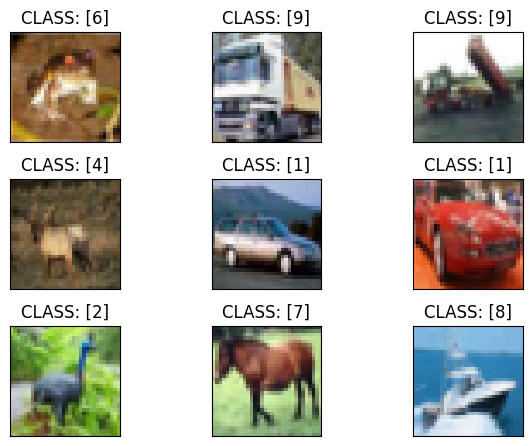

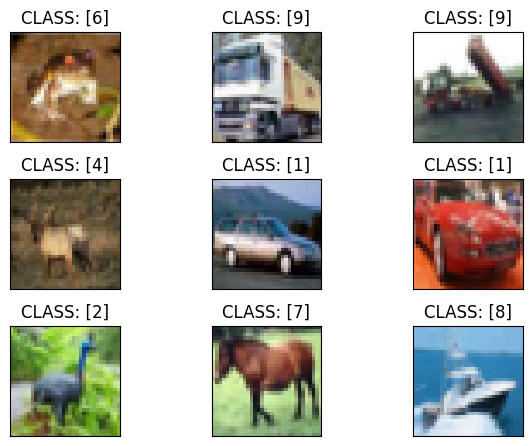

In [5]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("CLASS: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

**Conocer clases que existen**

In [6]:
clases = np.unique(y_train)
nombres_clases = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
i=0
for clase in clases:
    print(clase,':',nombres_clases[i])
    i=i+1
    
num_clases = len(clases)
print('Numero total de clases: ', num_clases)
print('Tipos de clases: ', clases)

0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck
Numero total de clases:  10
Tipos de clases:  [0 1 2 3 4 5 6 7 8 9]


Cómo se evidencia, existen 10 tipos de clases para clasificar.

La información de cómo clasifican la base, fue sacada de la data brindada de la base: (https://www.cs.toronto.edu/~kriz/cifar.html)



> **Pre-procesamiento  imágenes (Flatening)**





*   Normalizamos la data. 
*   Primero convertimos la data a float32 para representar los decimales con 32 bits y tener una mejor precision






In [7]:
def normalizarData(x_train, x_test):
  x_train_normalizado = x_train.astype('float32') / 255
  x_test_normalizado = x_test.astype('float32') / 255
  return x_train_normalizado, x_test_normalizado

x_train, x_test = normalizarData(x_train, x_test)

En este procesamiento, mantuvimos el tamaño de la imagen 32x32, dado que no es muy grande.



> **División de la data ( Entrenamiento y Validación)**



La división de la data de entrenamiento, se hizo con un 30 % para validación y 70 % para entrenamiento

In [8]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.30, random_state=1)

print(x_train.shape,x_val.shape)
print(y_train.shape,y_val.shape)

(35000, 32, 32, 3) (15000, 32, 32, 3)
(35000, 1) (15000, 1)




> **Evaluar Red**



Esto se hace, para ver si el modelo presenta Sobre-Ajuste, Sub-ajuste, Gradientes que explotan o desvanecen

In [9]:
def evaluate(model, history):
    # Se evalúa el accuracy del modelo tanto en el conjunto de entrenamiento como 
    # en el de prueba.
    _, train_accuracy = model.evaluate(x_train, y_train)
    _, test_accuracy = model.evaluate(x_test, y_test)

    print(f"Trainining accuracy: {train_accuracy:.2f}")
    print(f"Testing accuracy: {test_accuracy:.2f}")

    # Se grafica la función de pérdida para los conjuntos de entrenamiento y 
    # prueba.
    plt.figure(figsize=(6, 4), dpi=160)

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.show()



>  **Definición de Red (Convolucional)**



In [10]:
convolucion = keras.Sequential([
    #La primera capa oculta, se compone de una capa de convolución:
    #- 16 Filtros de size= 2X2
    #- Padding = "same", con el fin de no perder información ya que la imagen es pequeña
    #- Stride = 1 y activación relu
    #- Tamaño de imágenes de entrada (32,32,3)
    #- Con los hiperparámetros elegidos, la salida de la convolución será de tamaño 32x32x16
    keras.layers.Conv2D(filters = 16, kernel_size = (2, 2), padding="same", 
                        strides=(1, 1), activation='relu',input_shape=(32, 32, 3)),
    # Luego, el resultado de la capa de convolución pasa a través de una capa de 
    # Max Pooling que usa filtros 2x2 y un paso de 2. De esta forma, la salida 
    # de esta capa será de tamaño 16x16x32 
    keras.layers.MaxPooling2D(pool_size =(2, 2), strides=(2, 2)),

    # Definimos una nueva capa convolucional
    # Los hiper-parámetros restantes se mantienen iguales con respecto a la anterior capa.
    # Los filtros aumentan cada vez que aumentamos las capas
    # Con los hiperparámetros elegidos, la salida de la convolución será de tamaño 16x16x32
    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding="same", 
                        strides=(1, 1), activation='relu'),
    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding="same", 
                        strides=(1, 1), activation='relu'),
    # Finalizamos esta capa oculta con una operación de Pooling, la cual reduce 
    # la representación a un tamaño de 8x8x32
    keras.layers.MaxPooling2D(pool_size =(2, 2), strides=(2, 2)),


    # Definimos una nueva capa convolucional
    # Con los hiperparámetros elegidos, la salida de la convolución será de tamaño 8x8x64
    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding="same",
                        strides=(1, 1), activation='relu'),
    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding="same",
                        strides=(1, 1), activation='relu'),
    # Finalizamos esta capa oculta con una operación de Pooling, la cual reduce 
    # la representación a un tamaño de 4x4x64
    keras.layers.MaxPooling2D(pool_size =(2, 2), strides=(2, 2)),
])


In [11]:
model = keras.Sequential([
    # Se añade la función encargada del aumento de datos
    convolucion,

    # Las capas convolucionales funcionan como un artefacto para extraer características
    # de las imágenes. Luego, estás características son usadas para cumplir con 
    # la tarea de aprendizaje. En nuestro caso, dicha tarea es de clasificación 
    # con 10 clases. Para esto, usaremos una capa de aplastamiento (Flatten), que
    # recordemos tiene como finalidad convertir un arreglo de múltiples dimensiones 
    # en uno con una única dimensión. De esta forma, dado que la entrada de esta 
    # es un arreglo de tamaño 4x4x64, la salida será un arreglo unidimensional
    # con 1024 unidades.

    keras.layers.Flatten(),

    # Se aplica una capa de Dropout con el fin de prevenir el sobre-ajuste.
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4, 4, 64)          69520     
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 79,770
Trainable params: 79,770
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
1094/1094 [==============================] - 18s 7ms/step - loss: 1.6960 - accuracy: 0.3743 - val_loss: 1.3922 - val_accuracy: 0.4907
Epoch 2/20
1094/1094 [==============================] - 6s 6ms/step - loss: 1.3025 - accuracy: 0.5293 - val_loss: 1.1778 - val_accuracy: 0.5802
Epoch 3/20
1094/1094 [==============================] - 7s 7ms/step - loss: 1.1339 - accuracy: 0.5950 - val_loss: 1.0052 - val_accuracy: 0.6469
Epoch 4/20
1094/1094 [==============================] - 8s 7ms/step - loss: 1.0255 - accuracy: 0.6350 - val_loss: 0.9147 - val_accuracy: 0.6791
Epoch 5/20
1094/1094 [==============================] - 6s 6ms/step - loss: 0.9417 - accuracy: 0.6665 - val_loss: 0.8714 - val_accuracy: 0.6949
Epoch 6/20
1094/1094 [==============================] - 7s 6ms/step - loss: 0.8807 - accuracy: 0.6891 - val_loss: 0.8382 - val_accuracy: 0.7047
Epoch 7/20
1094/1094 [==============================] - 6s 6ms/step - loss: 0.8406 - accuracy: 0.7027 - val_loss: 0.8515 - val_accuracy

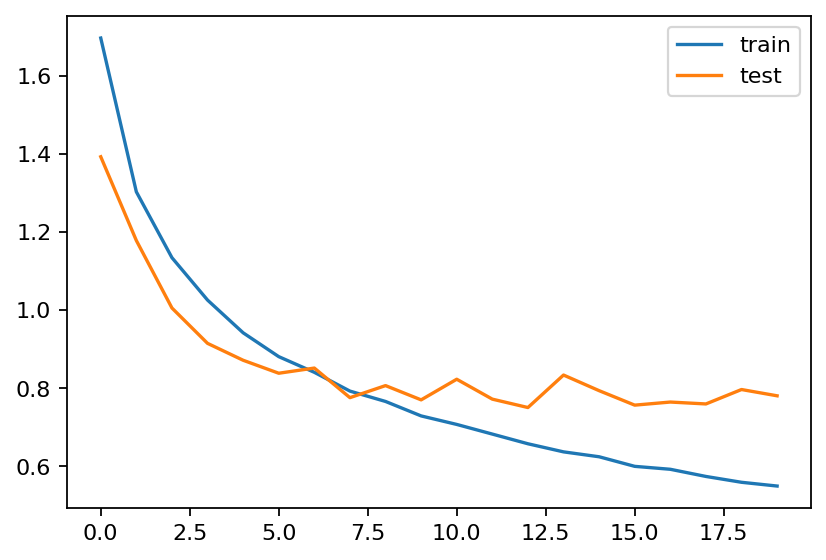

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history= model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

# Finalmente, se evalúa el rendimiento del modelo en el conjunto de entrenamiento.
evaluate(model,history)


Al ver la gráfica, concluimos que se presenta un sobre-ajuste, esto dado a que el accuracy del entrenamiento es del **0.86** y de la prueba es del **0.74**, lo que significa que la prueba no fue tan buena como el entrenamiento.

> **Sobre-ajuste**

*   **Data Augmentation**

Se decide dar uso de la ténica de data Augmentation, que consiste en aumentar los datos realizandole cambios a la orientación de la imágen



In [14]:
# Se define un modelo para realizar el aumento de datos
data_augmentation = tf.keras.Sequential([
  # realiza cambios en la orientación de forma aleatoria
  keras.layers.RandomFlip("horizontal"),
  # Rota las imágenes de forma aleatoria
  keras.layers.RandomRotation(0.1),
])

In [56]:
# Se modifica la red con el fin de usar los datos aumentados.
model_DA= keras.Sequential([
    # Se añade la función encargada del aumento de datos
    data_augmentation,
    convolucion,
    keras.layers.Flatten(),

    # se agraga una red fully-coneccted de dos capas ocultas
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2(l2=0.01)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='softmax')
])

Se hizo uso del Regularizador **L2** y **Dropout** para evitar el sobre-ajuste, el Dropout se definió con **0.25** dado que se realizaron diferentes pruebas y este valor fue el que mejor resultado obtuvo en cuanto a **accuracy** y **función de pérdida**.
con valores mayores a 0.25, el valor de la prueba aumentaba, pero la función tendía a presentar sub-ajuste, es decir, se obtenían mejores resultados en la prueba que en el entrenamiento.

La red fully-connected se decidió agregarle una capa oculta antes de la de salida para mejorar el porcentaje en la precisión de la clasficación

Epoch 1/20
1094/1094 [==============================] - 12s 8ms/step - loss: 1.4423 - accuracy: 0.6092 - val_loss: 0.9629 - val_accuracy: 0.7513
Epoch 2/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.8962 - accuracy: 0.7380 - val_loss: 0.8491 - val_accuracy: 0.7699
Epoch 3/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.8170 - accuracy: 0.7590 - val_loss: 0.7754 - val_accuracy: 0.7792
Epoch 4/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.7797 - accuracy: 0.7692 - val_loss: 0.8830 - val_accuracy: 0.7625
Epoch 5/20
1094/1094 [==============================] - 9s 8ms/step - loss: 0.7738 - accuracy: 0.7702 - val_loss: 0.7754 - val_accuracy: 0.7813
Epoch 6/20
1094/1094 [==============================] - 10s 9ms/step - loss: 0.7683 - accuracy: 0.7726 - val_loss: 0.7789 - val_accuracy: 0.7761
Epoch 7/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.7564 - accuracy: 0.7742 - val_loss: 0.7703 - val_acc

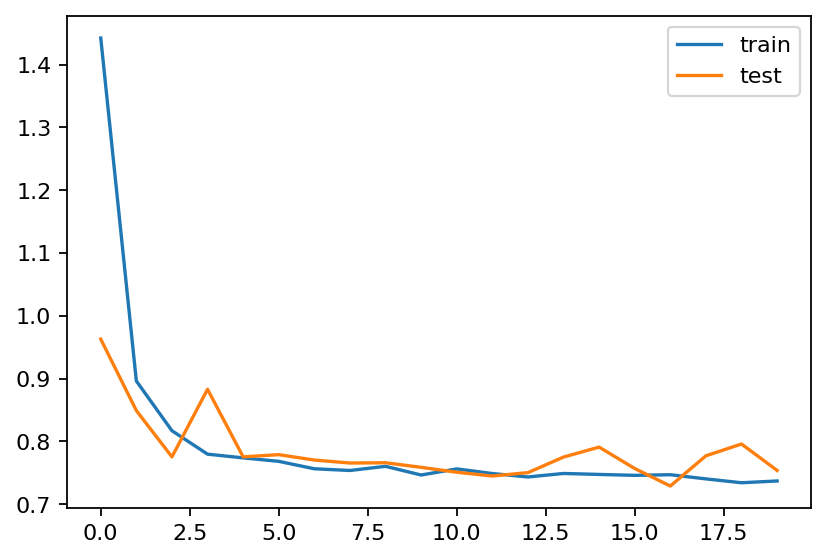

In [57]:
model_DA.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history= model_DA.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

# Finalmente, se evalúa el rendimiento del modelo en el conjunto de entrenamiento.
evaluate(model_DA,history)
